# Rainbow

A notebook exploring rainbow / water-droplet geometry.

We build a conceptual picture of a rainbow using four ideas chained together; and then write up the results as Python code with a couple of plots to see if the results are self-consistent. Here are the ideas: 

* Rainbows are formed from the partial reflection/refraction of light incident on water droplets. The light arrives from the sun (say) at a low grazing angle (say) from behind the viewer's back. It impinges on the water droplets suspended in the air and the pattern of reflected light is interpreted by the viewer as arcs of concentric color. 
* Water droplets are spherical and suspended in the air, moving slowly enough that we can consider them momentarily stationary. 
* Light enters each water droplet in a spatially even distribution of parallel rays as if from an infinitely distant point source. We do not consider the solid angle subtended by the sun.
* Light entering the water droplet obeys Snell's law, traveling in a plane defined by two vectors: The incident velocity vector and the vector normal to the sphere at the point of incidence. This plane passes through the center of the circle, i.e. it is a circular disc bisecting the spherical droplet. 
* The radius of the droplets is immaterial and is taken to be 1. The scattering of light is calculated for a single droplet and then the effect of many such scatterers is considered.
* While many incident light particles scatter off the droplet, and while many more will pass through the back of the droplet, we are concerned only with backscatter and therefore only the following trajectory: 
    * The incident light particle (photon) enters the droplet
        * Its path bends on entry per Snell's law
    * The photon reflects off the back of the droplet thereby staying inside the droplet
        * Its path obeys angle of incidence = angle of reflection off the plane tangent to the droplet surface
    * The photon impinges a second time on the surface of the droplet, this time passing through it
        * Undergoing another path bend per Snell's law
* We consider a uniform distribution of incident particles on the unit circle (the disc bisecting the droplet) from y = 0 aligned with the center of the droplet to y = 1 grazing the top of the droplet.

In [129]:
%matplotlib inline

import numpy as np

In [130]:
epsilon = 0.001
domain = np.arange(-pi/2., pi/2.0, epsilon)
print type(domain)

<type 'numpy.ndarray'>


In [131]:
bins = domain.shape[0]
scale = float(bins)
blueRange = np.zeros(bins)
redRange = np.zeros(bins)

print redRange.shape

# print domain.ndim

(3142L,)


In [149]:
def indexOfRefraction(wavelength):
    if (wavelength < 400.0): return
    if (wavelength > 700.0): return
    ind400 = 1.339
    ind700 = 1.331
    deltaind = ind700 - ind400
    deltawavefraction = (wavelength - 400.0)/300.0
    return (deltaind * deltawavefraction) + ind400


In [150]:
def dropangle(y, wavelength):
    if (y < 0.0):
        return
    elif (y > 1.0): 
        return
    indWater = indexOfRefraction(wavelength)
    indAir = 1.00029
    theta1 = np.arcsin(y)
    theta2 = np.arcsin(np.sin(theta1)*(indAir/indWater))
    return 4.0*theta2-2.0*theta1


In [134]:
def getbin(theta):
    if (theta < -np.pi/2.0): return
    if (theta > np.pi/2.0): return
    
    bin = int((theta+np.pi/2.0)*(scale/np.pi))
    if (bin >= 0 and bin < bins):
        return bin


In [135]:
# sin theta-new / sin theta-old = index-old / index-new
def getThetaWater(thetaAir, indexAir, indexWater):
    term = (indexAir / indexWater) * sin(thetaAir)
    return arcsin(term)

In [136]:
# Same as above but reversing the calculation
def getThetaAir(thetaWater, indexWater, indexAir):
    term = (indexWater / indexAir) * sin(thetaWater)
    return arcsin(term)

In [137]:
# Snell's law generalization to incident and transmission media
def snell(thetaInc, indexInc, indexTrans):
    return arcsin((indexInc/indexTrans)*sin(thetaInc))

In [138]:
# you just know this already exists
def rtd(theta): return theta*180.0/pi

In [139]:
# you just know this already exists
def dtr(theta): return theta*pi/180.0

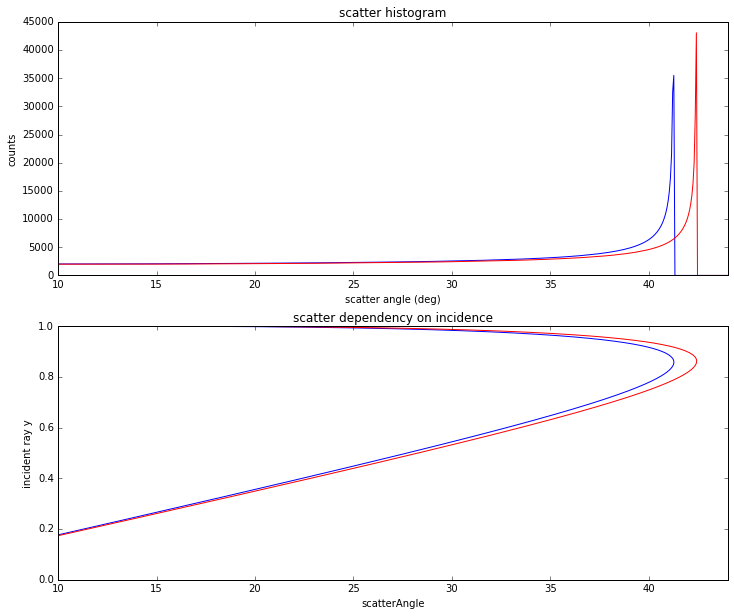

In [146]:
yIncident = []
angleRedDeg = []
angleBlueDeg = []

fig, axes = plt.subplots(2, figsize=(12,10))
ax0 = axes[0]
ax1 = axes[1]

for y in np.arange(0.0, 1.0, 0.000001):
    yIncident.append(y)
    thetaRed = dropangle(y, 700.0)
    thetaBlue = dropangle(y, 400.0)
    angleRedDeg.append(rtd(thetaRed))
    angleBlueDeg.append(rtd(thetaBlue))
    redBin = getbin(thetaRed)
    blueBin = getbin(thetaBlue)
    if blueBin >= 0 and blueBin < bins: blueRange[blueBin] += 1
    if redBin >= 0 and redBin < bins: redRange[redBin] += 1
  
# print type(domain)
# print type(histogram)
# plt.plot(domain, histogram)

domainDegrees = domain * 180.0 / pi

ax0.plot(domainDegrees, blueRange, 'b')
ax0.plot(domainDegrees, redRange, 'r')
ax0.set(xlim=(10.0, 44.0))
ax0.set(xlabel='scatter angle (deg)', ylabel = 'counts', title='scatter histogram')

ax1.plot(angleBlueDeg, yIncident, 'b')
ax1.plot(angleRedDeg, yIncident, 'r')
ax1.set(xlim=(10.0, 44.0))
ax1.set(ylabel='incident ray y', xlabel = 'scatter angle (deg)', title='scatter dependency on incidence')



In [141]:

maxRedIndex = np.where(redRange == redRange.max())[0][0]
maxBlueIndex = np.where(blueRange == blueRange.max())[0][0]
redMaxAngleDegrees = domain[maxRedIndex]*180.0/np.pi
blueMaxAngleDegrees = domain[maxBlueIndex]*180.0/np.pi

redMAD2 = round(redMaxAngleDegrees, 2)
blueMAD2 = round(blueMaxAngleDegrees, 2)
print 'red:', redRange.max(),', index', maxRedIndex, '     angle:', redMaxAngleDegrees
print 'blue:', blueRange.max(),', index', maxBlueIndex, '     angle:', blueMaxAngleDegrees
print 'Wikipedia rainbow is 42.00 - 40.89 =', 42.00 - 40.89, 'degrees wide'
print 'This rainbow is', redMAD2, '-', blueMAD2, '=', round(redMaxAngleDegrees - blueMaxAngleDegrees, 2), 'degrees wide'

# 40.89 to 42 (red) is 1.11 degrees (Wikipedia article on rainbows)
# My rainbow is 1.146 degrees wide


red: 21527.0 , index 2311      angle: 42.4105464547
blue: 17744.0 , index 2291      angle: 41.2646308645
Wikipedia rainbow is 42.00 - 40.89 = 1.11 degrees wide
This rainbow is 42.41 - 41.26 = 1.15 degrees wide


For wavelength 400 nm the max eject angle is 41.19 at incidence y = 0.84
For wavelength 700 nm the max eject angle is 42.41 at incidence y = 0.87


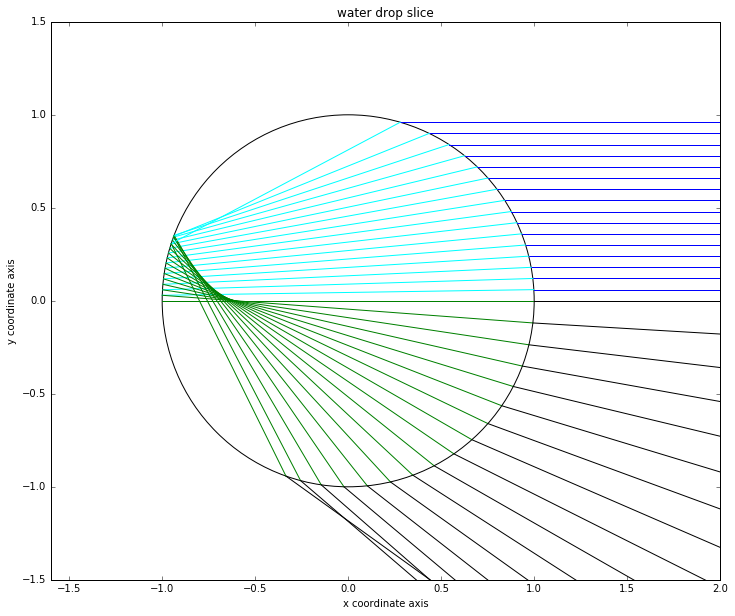

In [164]:
# let's do this the object way
%matplotlib inline

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(12,10))

# now we say that 'fig' is the overall canvas
# ax is the (list of) axes
# after this we leave fig alone and just use ax

# figure contains a bunch of axes (subplots(7)) and axis contains a bunch of artists

# How can we make the figure larger? 
# fig.set_figure()
# plt.figure(figsize=(12,12))
# fig = plt.figure(figsize=(12,10))

# a patch is a filled shape
# from matplotlib import patches
# patches.<tab> shows you them
ax.add_patch(plt.Circle((0, 0), 1, color = 'k', fill=False))

# Drawing a distant circle as the proxy for many observing eyes (ejected ray endpoint)
radiusCircleAtInf = 2.0
# ax.add_patch(plt.Circle((0, 0), radiusCircleAtInf, color = 'k', fill=False))

# unity aspect ratio
ax.axis('equal')

# How To note...
# ax.set_xlim(-7, 7)
# ax.set_ylim(-7, 7)

ax.set(xlim=(-1.1, 1.5), ylim=(-1.5,1.5))
ax.set(xlabel='x coordinate axis', ylabel = 'y coordinate axis', title='water drop slice')

maxEject = -pi
maxIncidentY = 0.0

colorScheme = 1
colorSelect = [
    [['blue','cyan','cyan','blue'],['red','orange','orange','red']], 
    [['blue','cyan','green','black'],['none','none','none','none']], 
    [['none','none','none','none'],['red','orange','orange','red']]  
    ]

for w in range(2):

    wavelength = 400 + 300*w

    # indices of refraction
    iorWater = indexOfRefraction(wavelength)
    iorAir = indAir = 1.00029

    yInterval = 0.06

    for y0 in arange(w*yInterval/2., 1.0, yInterval):
        # (x0, y0) is the point off at + infinity where one of the parallel rays comes in from
        x0 = 3.0

        # (x, y) is the point at which a ray intersects the surface of the droplet (radius = 1)
        # Call this point P
        # Call the center of the circle/sphere point C
        # Call (1, 0) the point U (for Unit). It is a convenient reference point.
        y = y0
        x  = np.sqrt(1.0-y*y)

        # here is our incident ray
        ax.plot([x0, x], [y, y], color=colorSelect[colorScheme][w][0])

        # Take out the radial lines to reduce clutter
        # ax.plot([0.0, x], [0.0, y], color='g')

        # incidenceAngle1 is measured relative to the circle (sphere) normal at (x, y)
        incidenceAngle1 = arctan2(y, x)

        # angleWater is the refracted angle: Bending in towards the normal line
        angleWater = snell(incidenceAngle1, iorAir, iorWater)
    
        # the ray will deflect and strike the far wall of the droplet at point Q
        # internal1 = angle QCP (a positive value; from isoscelesiness)
        internal1 = pi - 2*angleWater

        # internalTotal1 = angle QCU
        internalTotal1 = internal1 + incidenceAngle1

        # Q = (x2, y2)
        x2 = cos(internalTotal1)
        y2 = sin(internalTotal1)

        # Now draw the first leg of the journey inside the water drop
        ax.plot([x2, x], [y2, y], color=colorSelect[colorScheme][w][1])

        # The light reflects at Q using angle(incidence) = angle(reflection)
        # It will strike the surface of the droplet at point R
        # internal2 = angle QCR
        internal2 = pi - 2*angleWater              # the same as internal1!

        # internalTotal2 = RCU measured as positive from R clockwise to U
        internalTotal2 = internalTotal1 + internal2

        # R = (x3, y3)
        x3 = cos(internalTotal2)
        y3 = sin(internalTotal2)

        # Draw the second part of the path through the drop
        ax.plot([x2, x3], [y2, y3], color=colorSelect[colorScheme][w][2])
        # print rtd(angleWater)

        # externalTotal is the angle UCR measured from U clockwise to R 
        # It is 'external' because this angle is the angle of the normal at R
        externalTotal = 2*pi - internalTotal2

        # The rays will escape in some direction and intersect an outer circle of radius 'large'. 
        # S = the emergent ray's point of intersection with the outer circle = (x4, y4)

        # incidenceAngle2 = the incidence angle at R relative to the normal
        incidenceAngle2 = (pi - internal2)/2.

        # external = the transmission angle at R relative to the normal
        external = snell(incidenceAngle2, iorWater, iorAir)

        # ejectAngle is the angle at which the ray is ejected from the drop
        #   measured relative to the +x-axis direction. It will tend to be
        #   sign-changed in subsequent calculations; that is under the conditions
        #   established here it is technically negative. Soi sage.
        ejectAngle = externalTotal - external

        if ejectAngle > maxEject:
            maxEject = ejectAngle
            maxIncidentY = y0

        # Now we have triangle CRS from the center to the eject point R to the intersection
        #   of the ejected ray with Circle(radius 2) at point S. We need the coordinates of 
        #   S now. We could use a very large circle centered on R as an approximation for a
        #   very large circle centered at the origin C...
        radiusLarge = 1000.0
        x4 = radiusLarge * cos(-ejectAngle)
        y4 = radiusLarge * sin(-ejectAngle)
        ax.plot([x3, x4], [y3, y4], color=colorSelect[colorScheme][w][3])

    print 'For wavelength', wavelength, 'nm the max eject angle is',\
        round(rtd(maxEject),2), 'at incidence y =', maxIncidentY
        
fig.show()